In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import ConvHelper
import pickle
import math as math

In [2]:
DATA_PATH = "cifar-100-python"
STEPS = 50
MINIBATCH_SIZE = 100
n_classes = 100

class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None

    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d["data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1)\
                          .astype(float) / 255
        self.labels = one_hot(np.hstack([d["fine_labels"] for d in data]), n_classes)
        return self

    def next_batch(self, batch_size):
        x, y = self.images[self._i:self._i+batch_size],self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["train"]).load()
        self.test = CifarLoader(["test"]).load()


def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def one_hot(vec, vals=n_classes):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
                    for i in range(size)])
    plt.imshow(im)
    plt.show()
    
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b), W

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

def display_images(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.hstack([images[i] for i in range(size)])
    plt.title('True labels in images')
    plt.imshow(im)
    plt.show()
    
def display_custom1(custom_item):
    n_items = custom_item.shape[3]
    for i in range(n_items):
        plt.imshow(cv1[0,:,:,i],cmap = "gray")
        plt.show()

def display_filters(custom_item):
    print "Filters Input :", custom_item.shape
    plotNNFilter(custom_item)
    

        
def plotNNFilter(units):
    filters = units.shape[3]
    
    n_columns = 8
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.figure(i, figsize=(20,20))
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[:,:,1,i], interpolation="nearest", cmap="gray")


    
def display_filters(custom_item):
    #print "Filter Input :", custom_item.shape
    plotNNFilter(custom_item)
    
def plotNNFilter(units):
    filters = units.shape[3]
    fig = plt.figure(100, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    plt.axis('off')
    ax = fig.gca()
    ax.grid(False)
    for i in range(filters):
        #print "Unit shape :",units[:,:,:,i].shape
        disp_img = units[:,:,:,i].reshape((units.shape[0],units.shape[1],units.shape[2]))
        #print "Disp_img shape :",disp_img.shape
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('L-1 Filter ' + str(i))
        plt.imshow(disp_img, interpolation="nearest", cmap="gray")
        
def display_filters_with_depth(custom_item):
    print "Filter Input :", custom_item.shape
    plotNNFilter_with_depth(custom_item)
    
def plotNNFilter_with_depth(units):
    filters = units.shape[3]
    plt.figure(200, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    plt.axis('off')
    for i in range(filters):
        depth = units.shape[2]
        for j in range(depth):
            #print "Unit shape :",units[:,:,:,i].shape
            disp_img = units[:,:,j,i].reshape((units.shape[0],units.shape[1]))
            #print "Disp_img shape :",disp_img.shape
            plt.subplot(n_rows, n_columns, i+1)
            plt.title('L-2 Filter ' + str(i))
            plt.imshow(disp_img, interpolation="nearest", cmap="gray")

def display_feature_map(custom_item, i):
    #print "Feature Map Input :", custom_item.shape
    plotNNFeatureMap(custom_item, i)
        
def plotNNFeatureMap(units, image_index):
    filters = units.shape[3]
    plt.figure(image_index, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Feature Map ' + str(i))
        plt.imshow(units[image_index,:,:,i], interpolation="nearest", cmap="gray")

In [3]:
num_of_samples_to_test = 10

def test(sess):
    print "Starting Test"
    X = cifar.test.images.reshape(num_of_samples_to_test, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(num_of_samples_to_test, 1000, n_classes)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_: Y[i],
                                                 keep_prob: 1.0})
                   for i in range(num_of_samples_to_test)])
    print "Accuracy: {:.4}%".format(acc * 100)

In [4]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(tf.float32)


x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

shape1=[5, 5, 3, 32]
W1 = weight_variable(shape1)
conv1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='SAME')
conv1_pool = ConvHelper.max_pool_2x2(conv1)

shape2 = [5, 5, 32, 64]
W2 = weight_variable(shape2)
conv2 = tf.nn.conv2d(conv1_pool, W2, strides=[1, 1, 1, 1], padding='SAME')
conv2_pool = ConvHelper.max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.elu(ConvHelper.full_layer(conv2_flat, 1024))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = ConvHelper.full_layer(full1_drop, n_classes)

In [5]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= y_conv,
                                                               labels=y_))
loss = tf.reduce_mean(cross_entropy)
train_step = tf.train.AdamOptimizer(1e-5).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Starting
Starting epoch 0
Iter 0, Minibatch Loss= 6.255363
Starting epoch 1
Iter 1, Minibatch Loss= 5.235134
Starting epoch 2
Iter 2, Minibatch Loss= 4.774670
Starting epoch 3
Iter 3, Minibatch Loss= 4.516052
Starting epoch 4
Iter 4, Minibatch Loss= 4.346026
Starting epoch 5
Iter 5, Minibatch Loss= 4.215474
Starting epoch 6
Iter 6, Minibatch Loss= 4.112409
Starting epoch 7
Iter 7, Minibatch Loss= 4.026418
Starting epoch 8
Iter 8, Minibatch Loss= 3.951326
Starting epoch 9
Iter 9, Minibatch Loss= 3.884519
Starting epoch 10
Iter 10, Minibatch Loss= 3.825067
Starting epoch 11
Iter 11, Minibatch Loss= 3.771971
Starting epoch 12
Iter 12, Minibatch Loss= 3.723311
Starting epoch 13
Iter 13, Minibatch Loss= 3.678223
Starting epoch 14
Iter 14, Minibatch Loss= 3.635776
Starting epoch 15
Iter 15, Minibatch Loss= 3.594957
Starting epoch 16
Iter 16, Minibatch Loss= 3.555896
Starting epoch 17
Iter 17, Minibatch Loss= 3.518762
Starting epoch 18
Iter 18, Minibatch Loss= 3.483299
Starting epoch 19
Iter 

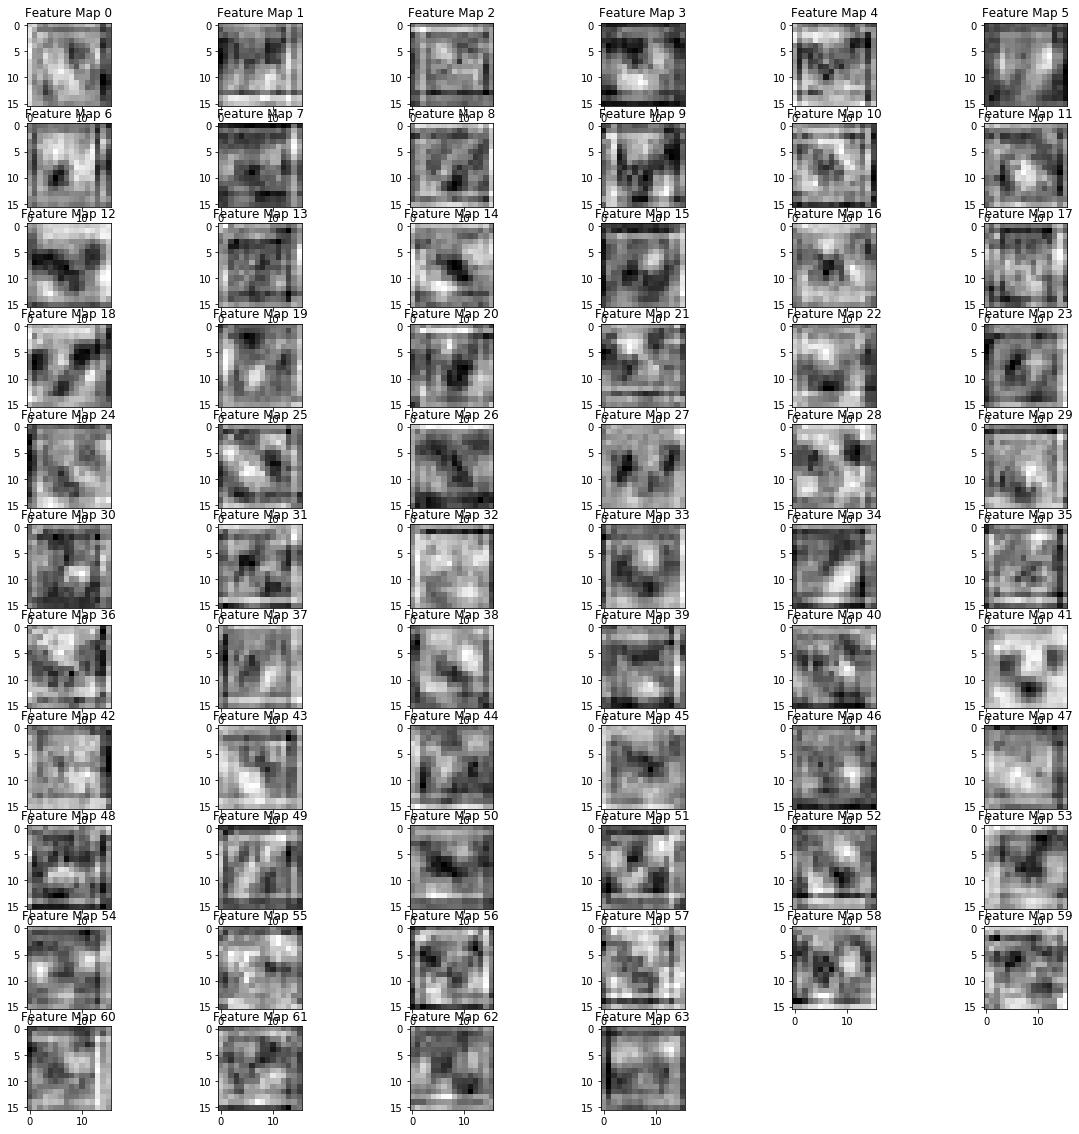

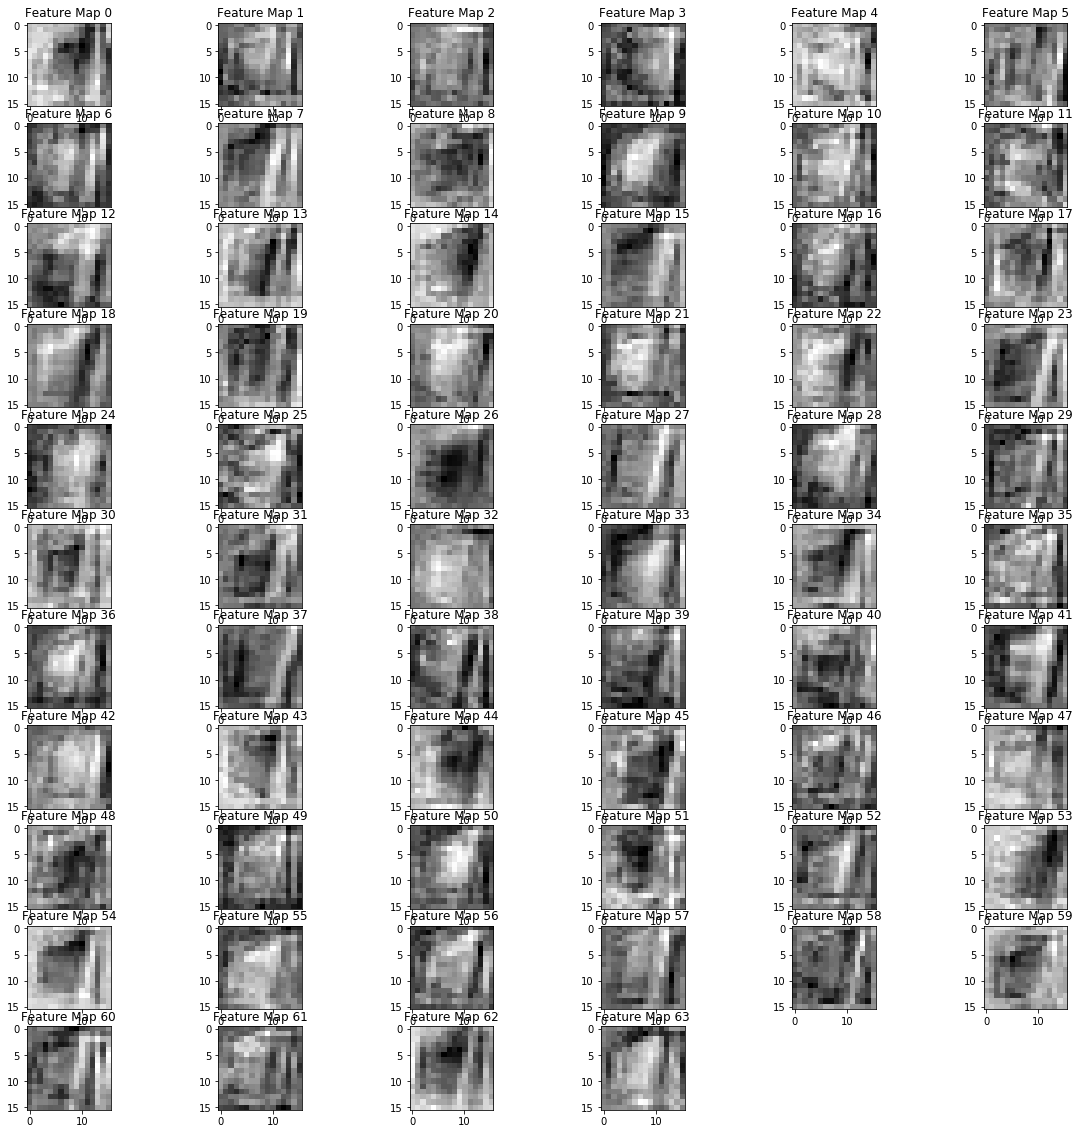

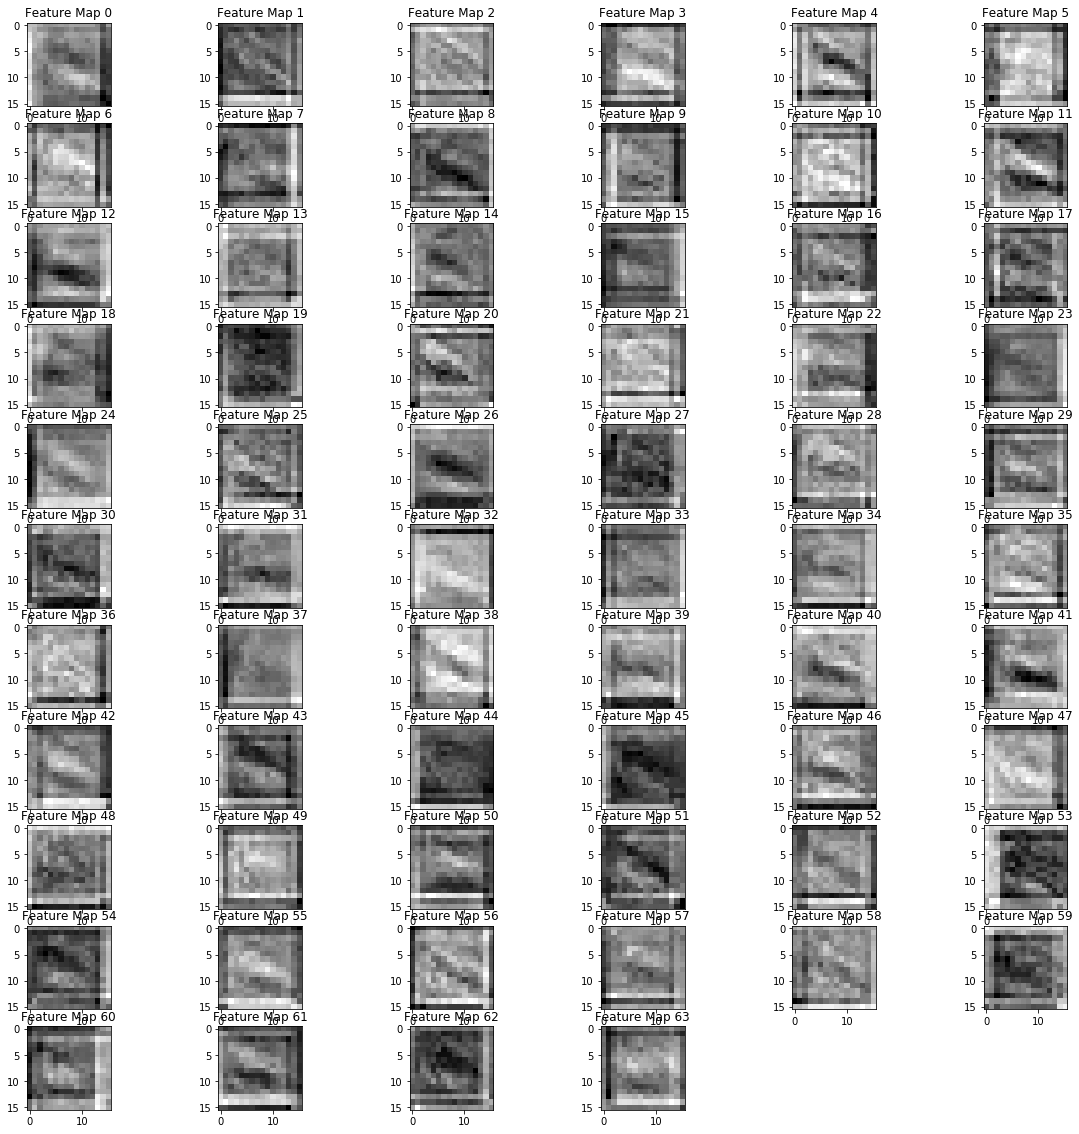

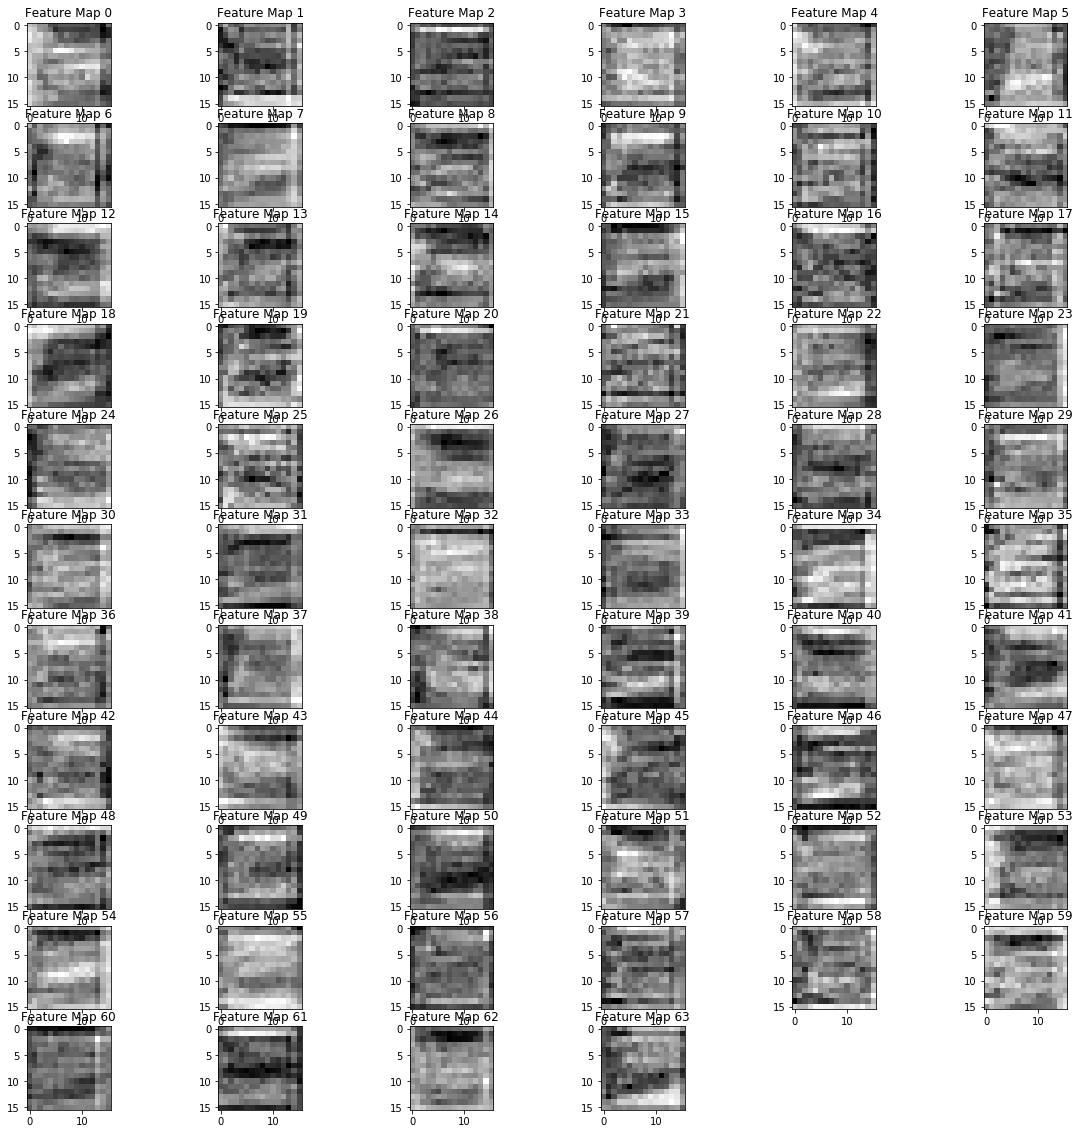

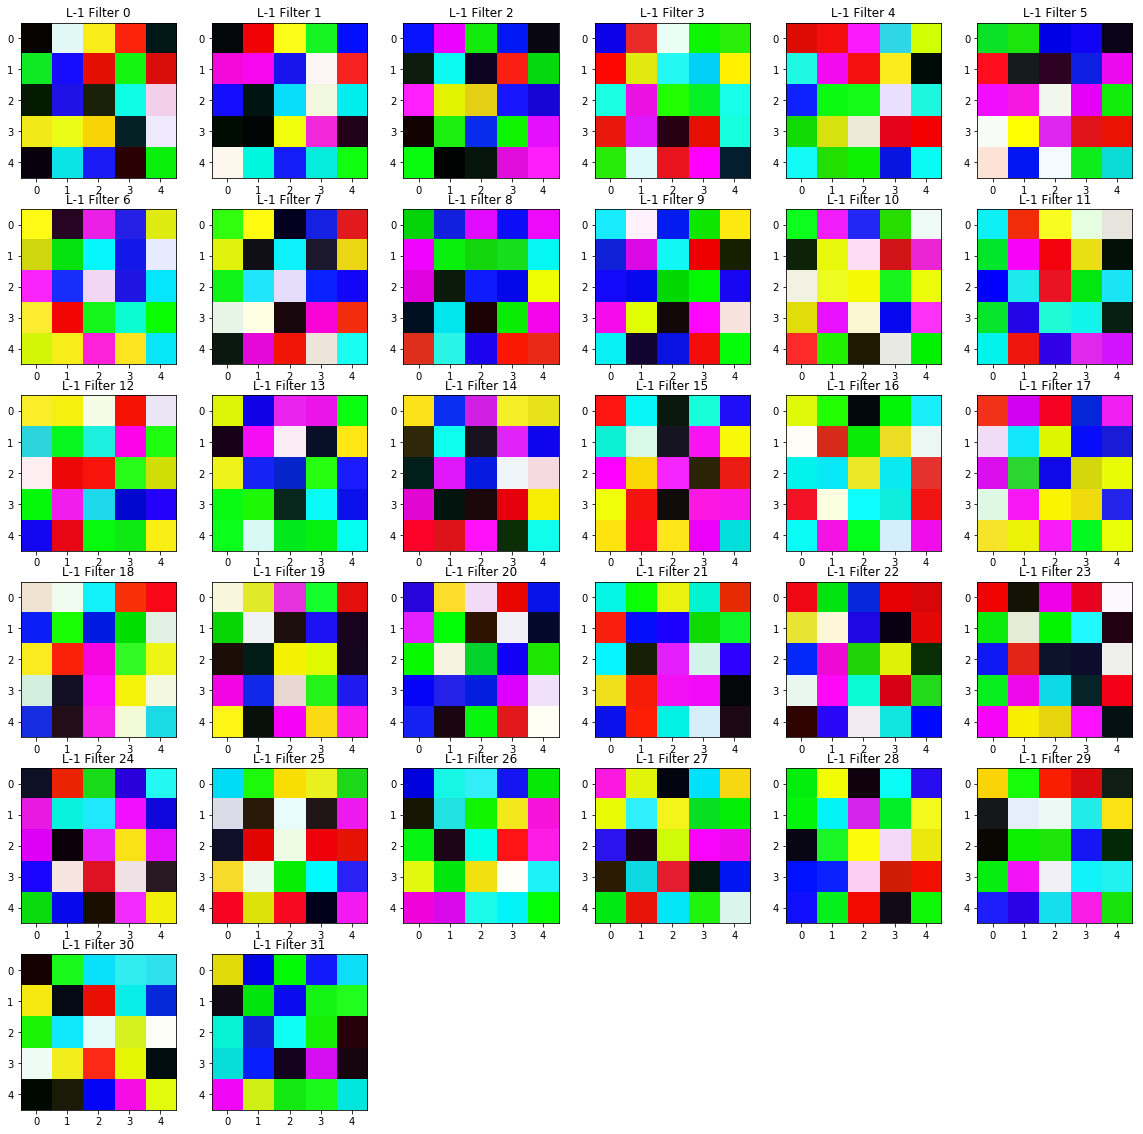

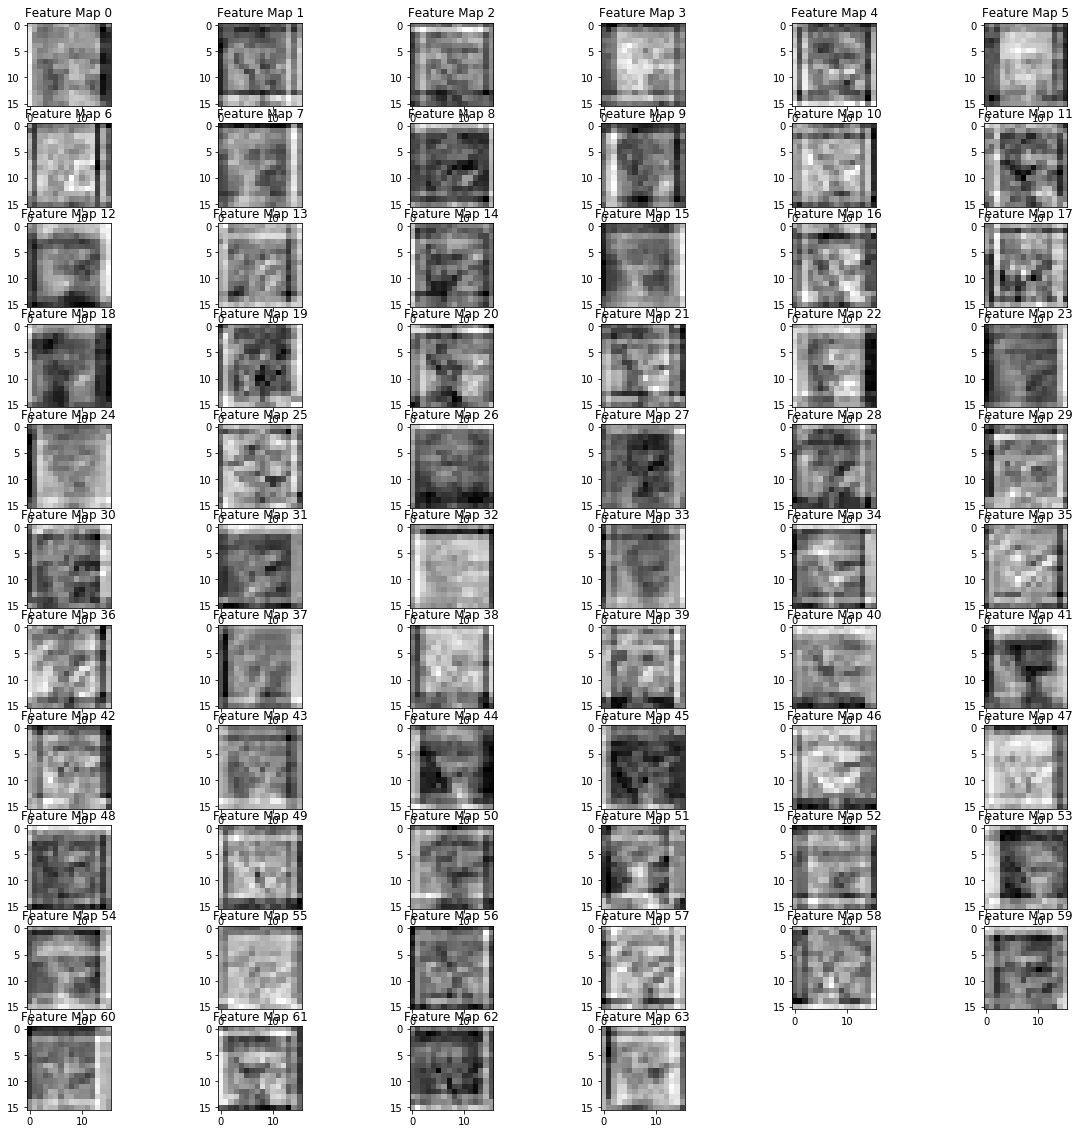

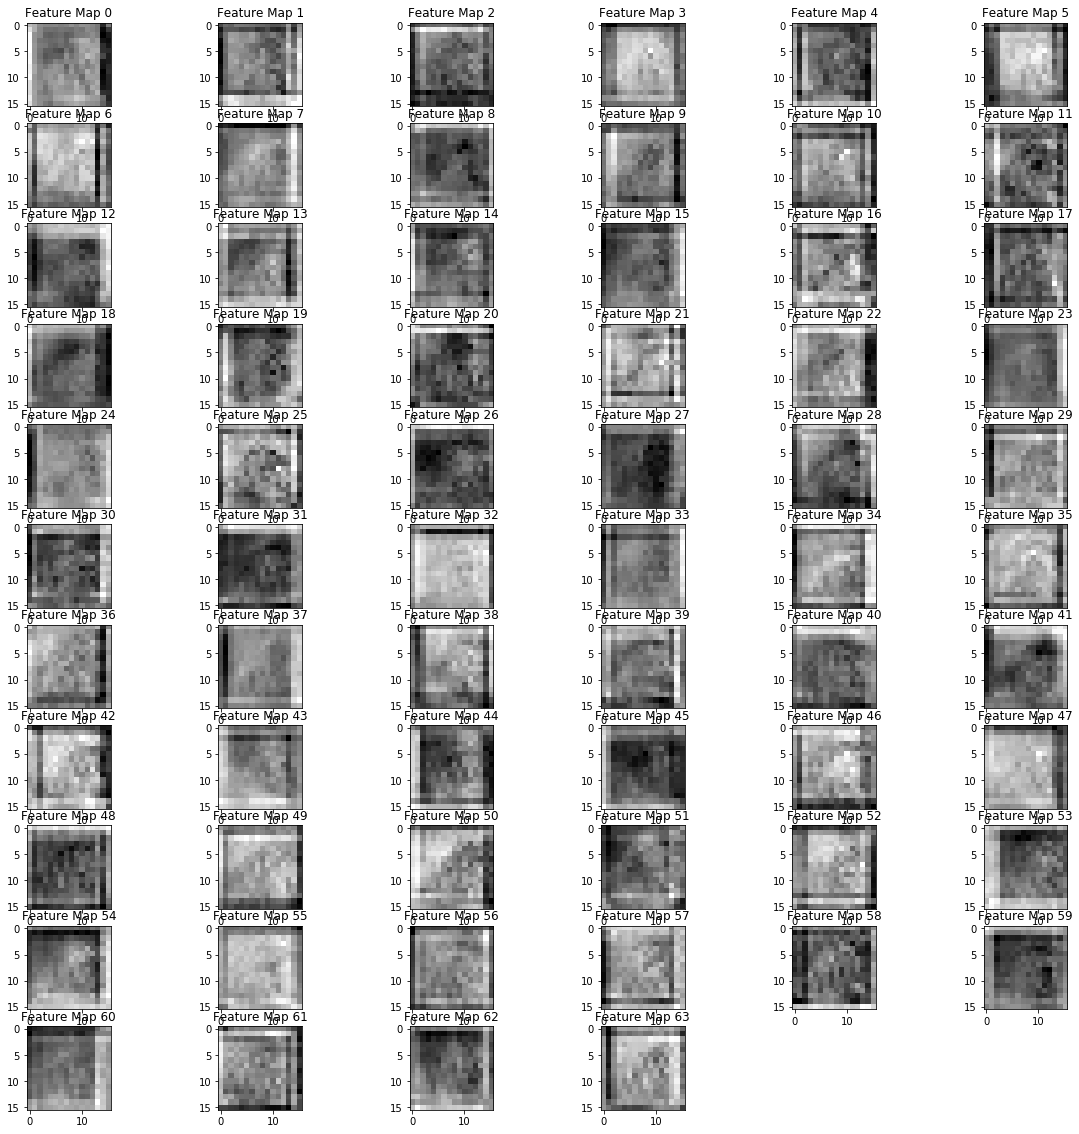

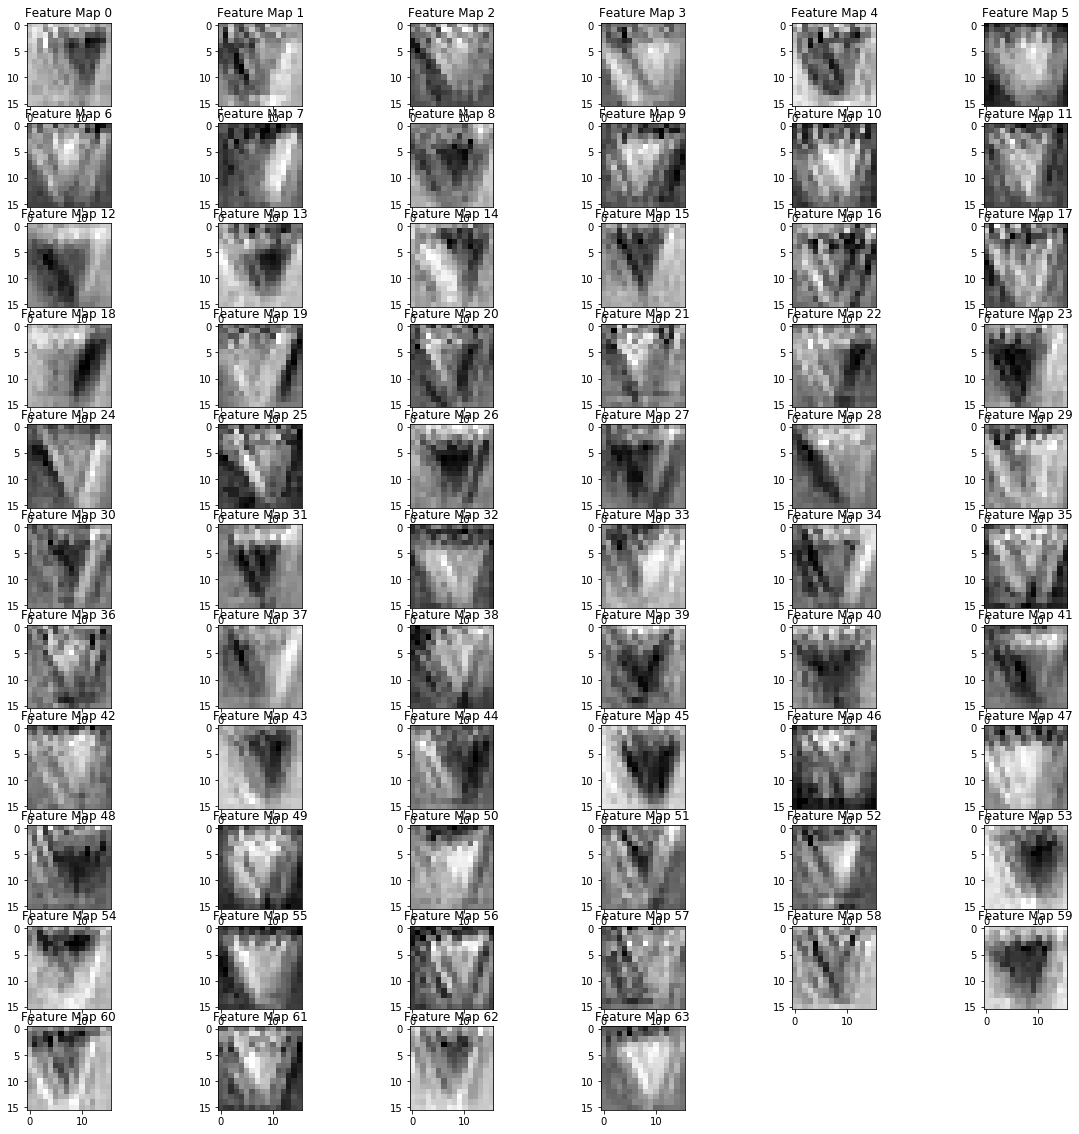

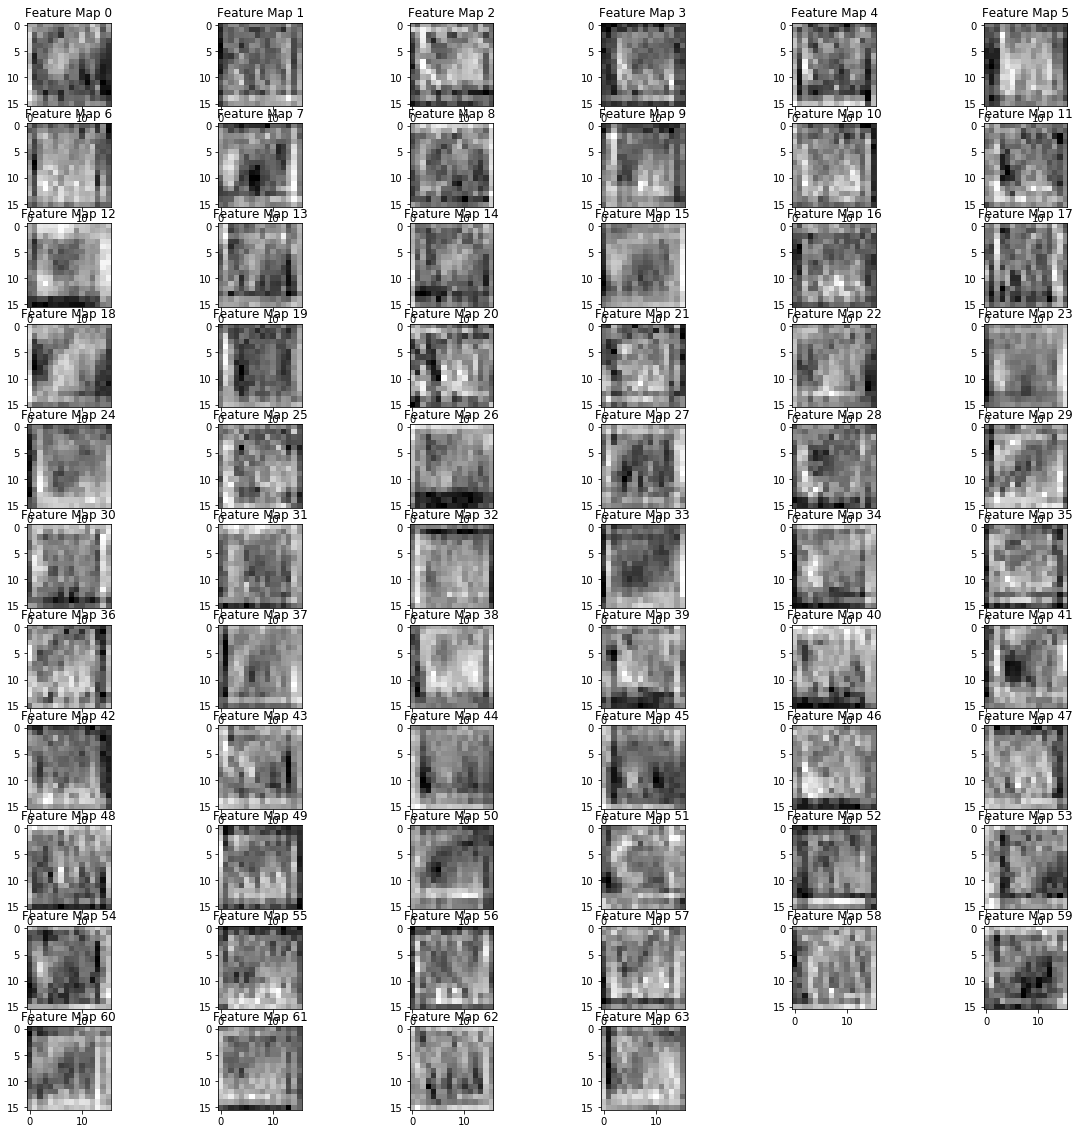

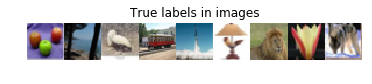

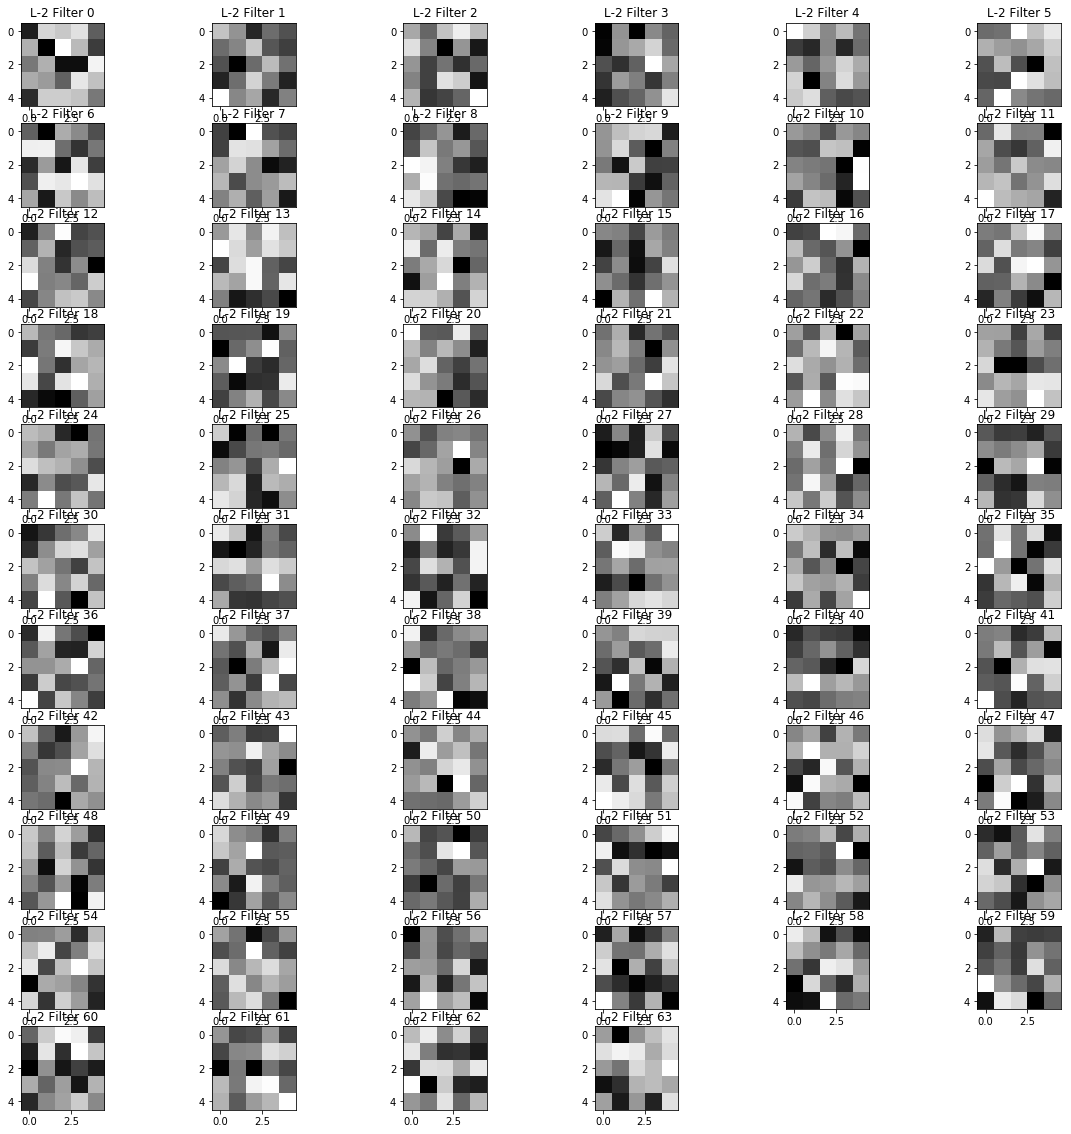

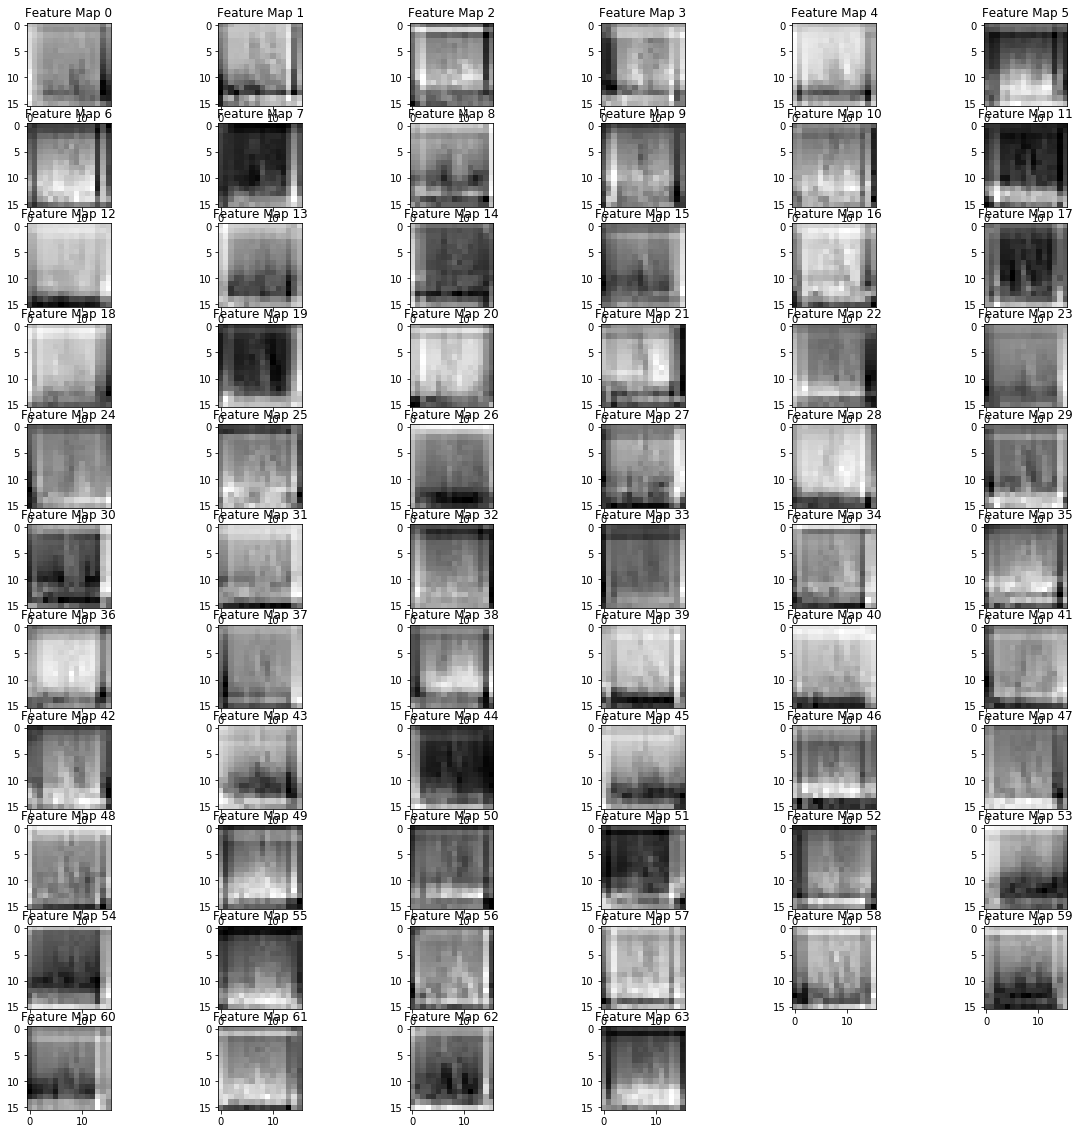

In [7]:
STEPS = 20
MINIBATCH_SIZE = 100

print "Starting"
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(STEPS):
        print "Starting epoch", epoch
        for batch_count in range(500):
            batch = cifar.train.next_batch(MINIBATCH_SIZE)
            sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                        keep_prob: 1.0})
        if(epoch%1 == 0):
            loss = sess.run(cross_entropy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print ("Iter " + str(epoch) + ", Minibatch Loss= " + \
                    "{:.6f}".format(loss) )
            #test(sess)

    test(sess)
    render_batch = cifar.test.next_batch(9)
    images = render_batch[0].reshape(9,32,32,3)
    filters1 = sess.run(W1,feed_dict = {x: render_batch[0]})
    display_filters(np.array(filters1))
    cv1 = sess.run(conv1,feed_dict = {x: render_batch[0]})
    for i in range(np.array(cv1).shape[0]):
        display_feature_map(np.array(cv1),i)
    filters2 = sess.run(W2,feed_dict = {x: render_batch[0]})
    display_filters_with_depth(np.array(filters2))
    cv2 = sess.run(conv2,feed_dict = {x: render_batch[0]})
    for i in range(np.array(cv2).shape[0]):
        display_feature_map(np.array(cv2),i)
    
    labs = sess.run(tf.argmax(y_conv, 1),feed_dict = {x: render_batch[0], y_: render_batch[1],keep_prob: 1.0})
    print "Predicted Labels:", labs
    display_images(images,9)
    #print "True Labels:", render_batch[1]


This experiment takes a lot of time to run on my machine. I believe I could have gotten a better accuracy than 19.86% 
if I had let it run for more iterations.